In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.tools import add_constant
import pickle
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', index_col=0)

In [3]:
for column in ['body_type', 'condition', 'isTradeSeller', 'make', 'model',
               'transmission', 'location', 'doors', 'manufactured_year', 'seats']:
    df[column] = df[column].astype('category')
    
for column in ['co2Emissions', 'mileage']:
    df[column] = df[column].astype('int64', copy=False)

df.engine_size = df.engine_size.astype('float64')

In [4]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4419 entries, 3764 to 212
Data columns (total 13 columns):
body_type            4419 non-null category
co2Emissions         4419 non-null int64
condition            4419 non-null category
doors                4419 non-null category
engine_size          4419 non-null float64
isTradeSeller        4419 non-null category
make                 4419 non-null category
manufactured_year    4419 non-null category
mileage              4419 non-null int64
model                4419 non-null category
seats                4419 non-null category
transmission         4419 non-null category
location             4419 non-null category
dtypes: category(10), float64(1), int64(2)
memory usage: 200.7 KB


In [6]:
X_train.shape

(4419, 13)

In [7]:
X_train.describe()

,co2Emissions,engine_size,mileage
count,4419.000000,4419.000000,4419.000000
mean,138.136004,1.563182,10697.938900
std,42.836666,0.841325,9454.739582
min,85.000000,0.900000,1.000000
25%,114.000000,1.000000,3800.000000
50%,127.000000,1.400000,8754.000000
75%,149.000000,1.600000,14821.000000
max,452.000000,6.750000,145000.000000


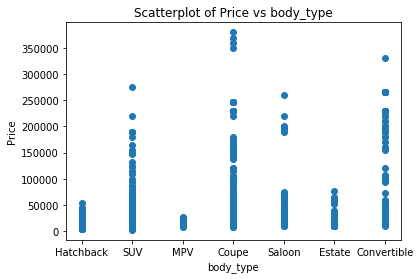

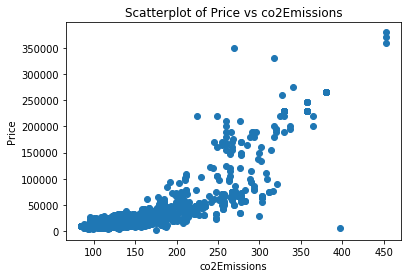

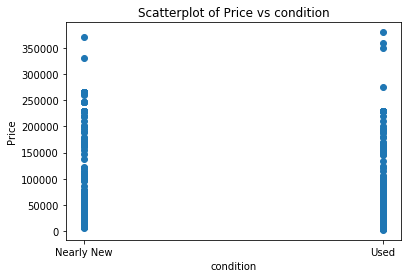

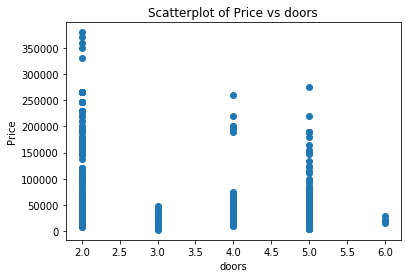

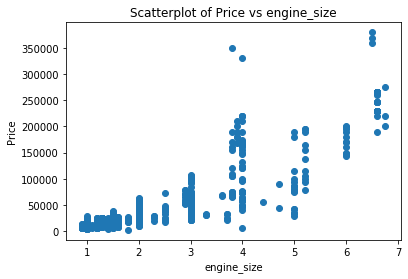

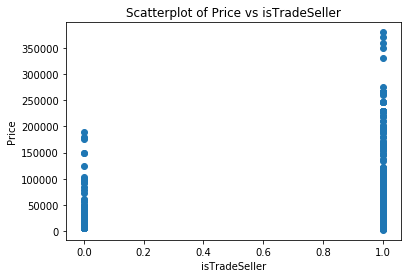

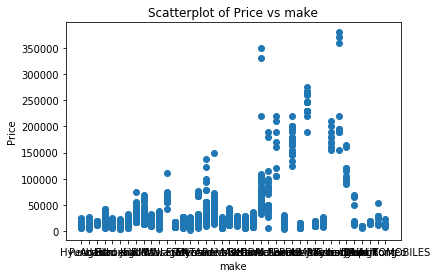

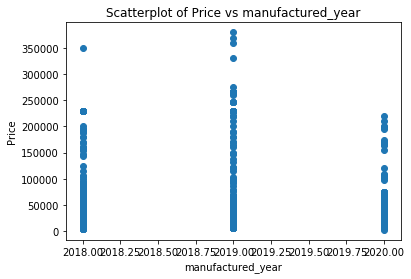

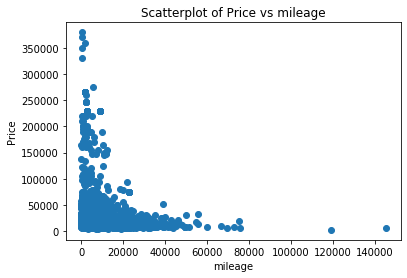

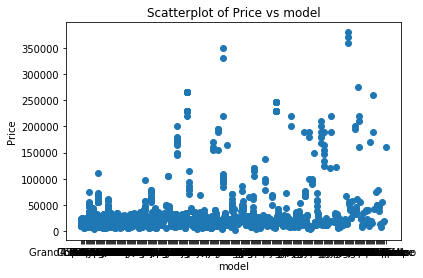

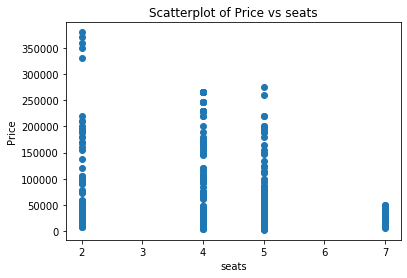

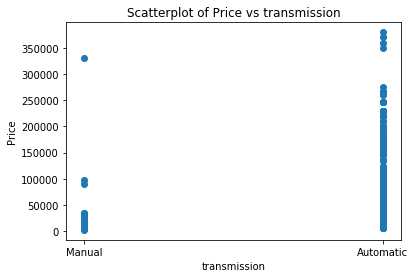

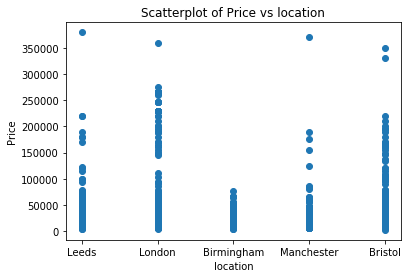

In [8]:
for column in X_train:
    #if (X[column].dtype == 'int64') | (X[column].dtype == 'float64'):
    plt.scatter(X_train[column], y_train)
    plt.xlabel(str(column))
    plt.ylabel("Price")
    plt.title(f"Scatterplot of Price vs {column}")
    plt.show()
    

Whilst scatterplots can be a little misleading in trying to ascertain how independent variables interact with the dependent variable, as it is not possible to view any interactions between independent variables that affect the target. However they can help give an insight into the data.

The plots seem to indicate a non-linear relationship for some variables. So it is worth taking note that a polynomial transformation could lead to a better model.

There appears to be an outlier on the CO2 emissions and transmission plots. This has been noted as something that may need investigating.

Text(0.5, 1.0, 'Histogram of price')

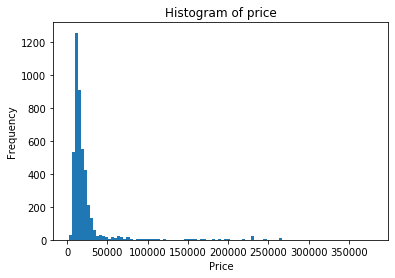

In [9]:
_ = plt.hist(y_train, bins=100)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of price")

The data will be scaled to allow for faster model training and encoded using one hot encoding to allow for the categorical features to be used.

In [10]:
#Scale the data to allow for better coefficient interpretation and quicker training
columns_to_scale = ['co2Emissions', 'mileage', 'engine_size']
scaler = StandardScaler()
array_train_columns = scaler.fit_transform(X_train[columns_to_scale])
array_test_columns = scaler.transform(X_test[columns_to_scale])

scaled_train_columns = pd.DataFrame(data=array_train_columns, columns=columns_to_scale)
scaled_test_columns = pd.DataFrame(data=array_test_columns, columns=columns_to_scale)


#Encoding categorical variables
columns_to_encode = ['body_type', 'condition', 'doors', 'isTradeSeller', 'make', 'manufactured_year', 'model', 'seats', 'transmission', 'location']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
array_encoded_train_columns = ohe.fit_transform(X_train[columns_to_encode])
array_encoded_test_columns = ohe.transform(X_test[columns_to_encode])

#Regularization will be applied during the model building step, so dummy variable trap is not an issue

#combine encoded and scaled data

X_train_scaled_encoded = np.concatenate([array_train_columns, array_encoded_train_columns], axis=1)
X_test_scaled_encoded = np.concatenate([array_test_columns, array_encoded_test_columns], axis=1)


In [11]:
print(X_train_scaled_encoded.shape)

(4419, 349)


In [12]:
#A simple linear model to provide a baseline
X_train_scaled_encoded = add_constant(X_train_scaled_encoded)
X_test_scaled_encoded = add_constant(X_test_scaled_encoded)

stats_linear_model = sm.OLS(y_train, X_train_scaled_encoded)
fitted_stats_model = stats_linear_model.fit()
fitted_stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     948.2
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        08:00:08   Log-Likelihood:                -42671.
No. Observations:                4419   AIC:                         8.594e+04
Df Residuals:                    4119   BIC:                         8.786e+04
Df Model:                         299                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.071e+16   1.01e+16      1.062      0.288   -9.07e+15    3.05e+16
x1          2244.2349    250.318      8.966      0.000    1753.477    2734.993
x2          -619.4501     80.095     -7.734      0.000    -776.479    -462.421
x3          4865.8008    269.589     18.049      0.000    4337.260    5394.341
x4          2.445e+15    2.3e+15      1.062      0.288   -2.07e+15    6.96e+15
x5          2.445e+15    2.3e+15      1.062      0.288   -2.07e+15    6.96e+15
x6          2.445e+15    2.3e+15      1.062      0.288   -2.07e+15    6.96e+15
x7          2.445e+15    2.3e+15      1.062      0.288   -2.07e+15    6.96e+15
x8           2.42e+15   2.28e+15      1.062      0.288   -2.05e+15    6.89e+15
x9          2.445e+15    2.3e+15      1.062      0.288   -2.07e+15    6.96e+15
x10         2.445e+15    2.3e+15      1.062      0.288   -2.07e+15    6.96e+15
x11        -3.353e+15   3.16e+15     -1.062      0.288   -9.54e+15    2.84e+15
x12        -3.353e+15   3.16e+15     -1.062      0.288   -9.54e+15    2.84e+15
x13        -3.657e+15   3.44e+15     -1.062      0.288   -1.04e+16     3.1e+15
x14        -3.657e+15   3.44e+15     -1.062      0.288   -1.04e+16     3.1e+15
x15        -3.657e+15   3.44e+15     -1.062      0.288   -1.04e+16     3.1e+15
x16        -3.657e+15   3.44e+15     -1.062      0.288   -1.04e+16     3.1e+15
x17        -9.605e+14   9.05e+14     -1.062      0.288   -2.73e+15    8.13e+14
x18        -1.128e+16   1.06e+16     -1.062      0.288   -3.21e+16    9.55e+15
x19        -1.128e+16   1.06e+16     -1.062      0.288   -3.21e+16    9.55e+15
x20         2.328e+14   2.19e+14      1.062      0.288   -1.97e+14    6.63e+14
x21           3.1e+14   2.92e+14      1.062      0.288   -2.62e+14    8.82e+14
x22         2.211e+14   2.08e+14      1.062      0.288   -1.87e+14    6.29e+14
x23         3.088e+14   2.91e+14      1.062      0.288   -2.61e+14    8.79e+14
x24         3.509e+14    3.3e+14      1.062      0.288   -2.97e+14    9.99e+14
x25         2.781e+14   2.62e+14      1.062      0.288   -2.35e+14    7.91e+14
x26         2.777e+14   2.62e+14      1.062      0.288   -2.35e+14     7.9e+14
x27         1.939e+14   1.83e+14      1.062      0.288   -1.64e+14    5.52e+14
x28         2.759e+14    2.6e+14      1.062      0.288   -2.34e+14    7.85e+14
x29         2.513e+14   2.37e+14      1.062      0.288   -2.13e+14    7.15e+14
x30         2.328e+14   2.19e+14      1.062      0.288   -1.97e+14    6.63e+14
x31         1.871e+14   1.76e+14      1.062      0.288   -1.58e+14    5.33e+14
x32         3.007e+14   2.83e+14      1.062      0.288   -2.55e+14    8.56e+14
x33         2.782e+14   2.62e+14      1.062      0.288   -2.35e+14    7.92e+14
x34         2.392e+14   2.25e+14      1.062      0.288   -2.02e+14    6.81e+14
x35         1.513e+14   1.43e+14      1.062      0.288   -1.28e+14    4.31e+14
x3

The OLS output is useful because the statistical preference can give some useful insights into the data. From the output, it can be seen that the standard errors are very large and very few are statistically significant. This points towards multicollinearity being an issue and this is confirmed by the Cond. No. of 2.49 e+16, a value below 30 is ideal. Whilst this doesn't affect the model's ability to make valid predictions, it can negatively influence the model's stability and signals that variable selection or regularization should be carried out.

In [13]:
with open('train.pickle', 'wb') as f:
    pickle.dump([X_train, y_train], f)
    
with open('test.pickle', 'wb') as f:
    pickle.dump([X_test, y_test], f)
    
with open('train_scaled.pickle', 'wb') as f:
    pickle.dump(X_train_scaled_encoded, f)

with open('test_scaled.pickle', 'wb') as f:
    pickle.dump(X_test_scaled_encoded, f)